In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
file_path = 'df_1.csv'
df = pd.read_csv(file_path)

In [5]:
print(df.columns)
print(df.dtypes)
print(df.head())

Index(['Unnamed: 0', 'Entity', 'Year', 'Records', 'Organization type',
       'Method', 'Sources'],
      dtype='object')
Unnamed: 0            int64
Entity               object
Year                 object
Records              object
Organization type    object
Method               object
Sources              object
dtype: object
   Unnamed: 0                      Entity  Year    Records  Organization type  \
0           0       21st Century Oncology  2016    2200000         healthcare   
1           1                       500px  2020   14870304  social networking   
2           2       Accendo Insurance Co.  2020     175350         healthcare   
3           3  Adobe Systems Incorporated  2013  152000000               tech   
4           4                  Adobe Inc.  2019    7500000               tech   

          Method   Sources  
0         hacked    [5][6]  
1         hacked       [7]  
2  poor security    [8][9]  
3         hacked      [10]  
4  poor security  [11][12]  


## Data cleaning

In [ ]:
# convert 'Year' to numeric
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# clean 'Records' column, remove non numeric characters
df['Records'] = df['Records'].replace('[^\d.]', '', regex=True)  
df['Records'] = pd.to_numeric(df['Records'], errors='coerce')  

# drop rows with missing/invalid 'Records'
df = df.dropna(subset=['Records'])

# drop rows with missing/invalid 'Year'/'Records'
df = df.dropna(subset=['Year', 'Records'])

In [ ]:
print(df.describe())
print(df.isnull().sum())

       Unnamed: 0         Year       Records
count  319.000000   319.000000  3.190000e+02
mean   175.194357  2013.811912  4.188392e+07
std    101.987266     4.410078  1.889050e+08
min      0.000000  2004.000000  2.500000e+00
25%     86.500000  2011.000000  2.357000e+05
50%    175.000000  2014.000000  1.500000e+06
75%    263.500000  2018.000000  1.493515e+07
max    351.000000  2022.000000  3.000000e+09
Unnamed: 0           0
Entity               0
Year                 0
Records              0
Organization type    0
Method               1
Sources              2
dtype: int64


In [ ]:
# custom descriptions for main types of breaches
breach_type_map = {
    'hacked': 'Hacking/Malware',
    'poor security': 'Poor Security',
    'lost / stolen media': 'Lost / stolen media',
    'lost / stolen computer': 'Lost / stolen computer',
    'inside job': 'Insider Leak',
    'unknown': 'Unknown'
}

df['breach_description'] = df['Method'].map(breach_type_map)

## Data visualization

In [ ]:
def analyze_breach_types(df):
    plt.figure(figsize=(12, 6))

    # count breaches by type
    breach_counts = df['breach_description'].value_counts()

    # bar plot
    sns.barplot(x=breach_counts.values, y=breach_counts.index)
    plt.title('Distribution of Breach Types')
    plt.xlabel('Number of Incidents')
    plt.tight_layout()
    plt.show()

    # statistics
    print("\nBreach Type Statistics:")
    print(breach_counts.to_frame().to_string())

def analyze_breach_timeline(df):
    plt.figure(figsize=(12, 6))

    # group by year and count incidents
    yearly_breaches = df.groupby('Year').size()

    # line plot
    plt.plot(yearly_breaches.index, yearly_breaches.values, marker='o')
    plt.title('Breach Incidents Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Incidents')
    plt.grid(True)

    plt.xticks(yearly_breaches.index.astype(int))  # Convert years to integers for x-axis

    plt.tight_layout()
    plt.show()

# displaying the top 15 organizations ranked by the number of records lost
def analyze_records_lost(df, top_n=15):
    plt.figure(figsize=(12, 6))

    # group by organization type and sum the number of records lost
    records_by_org = df.groupby('Organization type')['Records'].sum().sort_values(ascending=False)

    # limit to the top N (15) organizations
    records_by_org = records_by_org.head(top_n)

    # bar plot
    sns.barplot(x=records_by_org.values, y=records_by_org.index, palette='viridis')
    plt.title(f'Top {top_n} Organization Types by Total Records Lost')
    plt.xlabel('Total Records Lost (log scale)')
    plt.ylabel('Organization Type')
    plt.xscale('log')  # sse log scale for the x-axis as there is a large range of values
    plt.tight_layout()
    plt.show()

    # statistics
    print(f"\nTop {top_n} Organization Types by Total Records Lost:")
    print(records_by_org.to_frame().to_string())

def analyze_org_vulnerability(df, top_n=15):
    plt.figure(figsize=(12, 6))

    # get top n (15) organization types by number of breach incidents
    top_orgs = df['Organization type'].value_counts().head(top_n).index
    df_filtered = df[df['Organization type'].isin(top_orgs)]

    # heatmap of breach types by organization type
    breach_by_org = pd.crosstab(df_filtered['Organization type'], df_filtered['breach_description'])
    sns.heatmap(breach_by_org, annot=True, fmt='d', cmap='YlOrRd')
    plt.title(f'Breach Types by Top {top_n} Organization Types')
    plt.xlabel('Breach Type')
    plt.ylabel('Organization Type')
    plt.tight_layout()
    plt.show()

def generate_risk_metrics(df):
    # calculate a risk score for each organization type
    risk_metrics = pd.DataFrame()
    risk_metrics['breach_frequency'] = df.groupby('Organization type').size()
    risk_metrics['avg_records_lost'] = df.groupby('Organization type')['Records'].mean()
    risk_metrics['risk_score'] = (risk_metrics['breach_frequency'] *
                                np.log(risk_metrics['avg_records_lost'] + 1))  # Add 1 to avoid log(0)

    return risk_metrics

def run_complete_analysis(df):
    print("=== Cybersecurity Breach Analysis ===\n")

    print("Dataset Overview:")
    print(f"Total number of incidents: {len(df)}")
    print(f"Year range: {df['Year'].min()} to {df['Year'].max()}\n")

    # run all analyses
    analyze_breach_types(df)
    analyze_breach_timeline(df)
    analyze_records_lost(df)
    analyze_org_vulnerability(df)

    # generate and display risk metrics
    risk_metrics = generate_risk_metrics(df)
    print("\nOrganizational Risk Metrics:")
    print(risk_metrics.sort_values('risk_score', ascending=False).to_string())

    # summary statistics
    print("\nKey Findings:")
    print(f"Most common breach type: {df['breach_description'].mode()[0]}")
    print(f"Most targeted organization type: {df['Organization type'].mode()[0]}")
    print(f"Average records lost per breach: {df['Records'].mean():.0f}")
    print(f"Total records lost: {df['Records'].sum():,}")

=== Cybersecurity Breach Analysis ===

Dataset Overview:
Total number of incidents: 319
Year range: 2004.0 to 2022.0



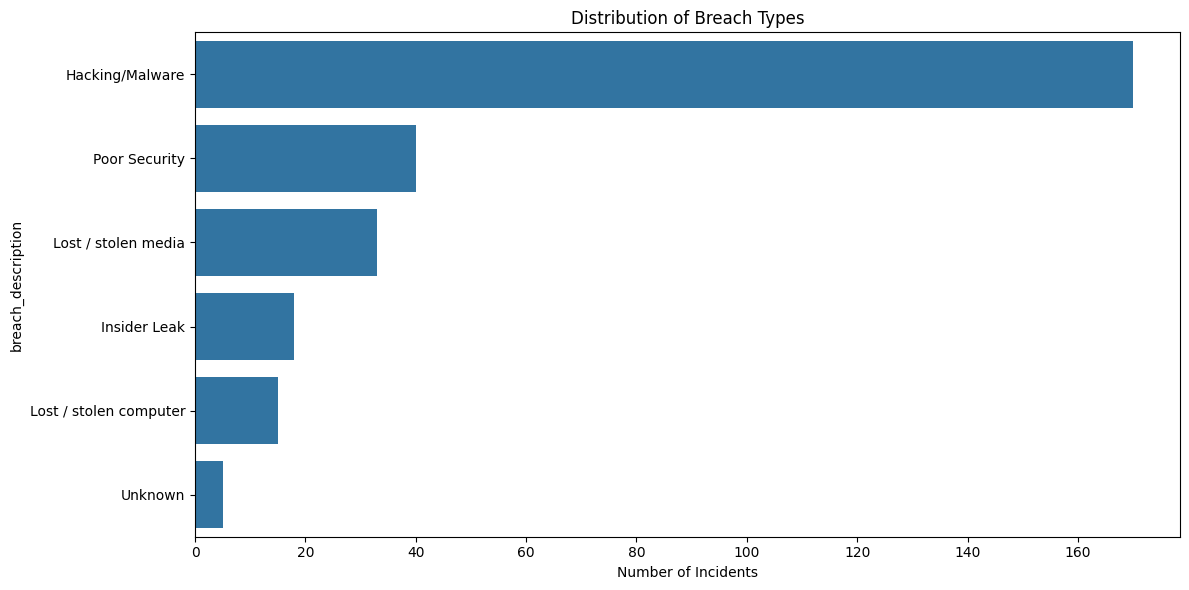


Breach Type Statistics:
                        count
breach_description           
Hacking/Malware           170
Poor Security              40
Lost / stolen media        33
Insider Leak               18
Lost / stolen computer     15
Unknown                     5


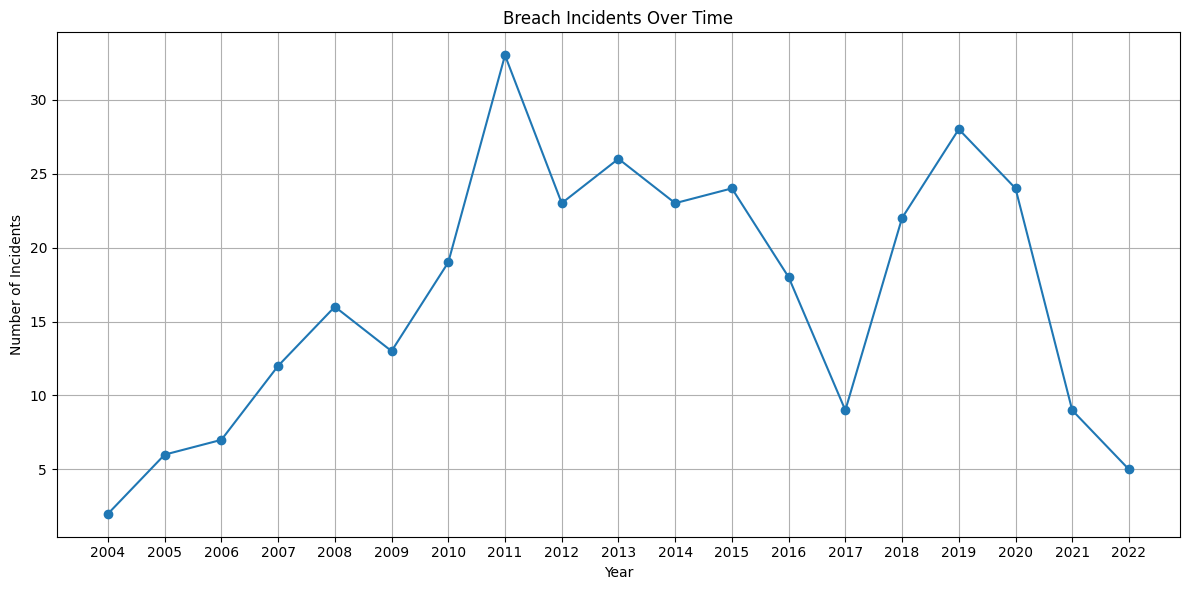

/tmp/ipython-input-9-2487284188.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=records_by_org.values, y=records_by_org.index, palette='viridis')


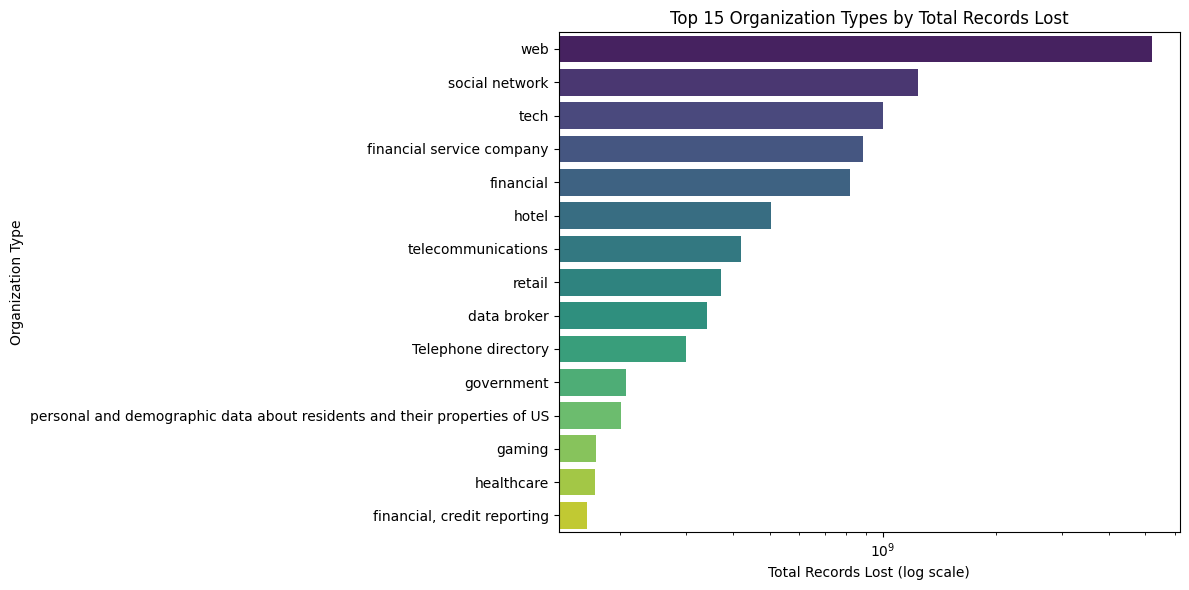


Top 15 Organization Types by Total Records Lost:
                                                                               Records
Organization type                                                                     
web                                                                       5.203696e+09
social network                                                            1.238000e+09
tech                                                                      1.000898e+09
financial service company                                                 8.850000e+08
financial                                                                 8.185971e+08
hotel                                                                     5.052003e+08
telecommunications                                                        4.200000e+08
retail                                                                    3.721411e+08
data broker                                                               3.4000

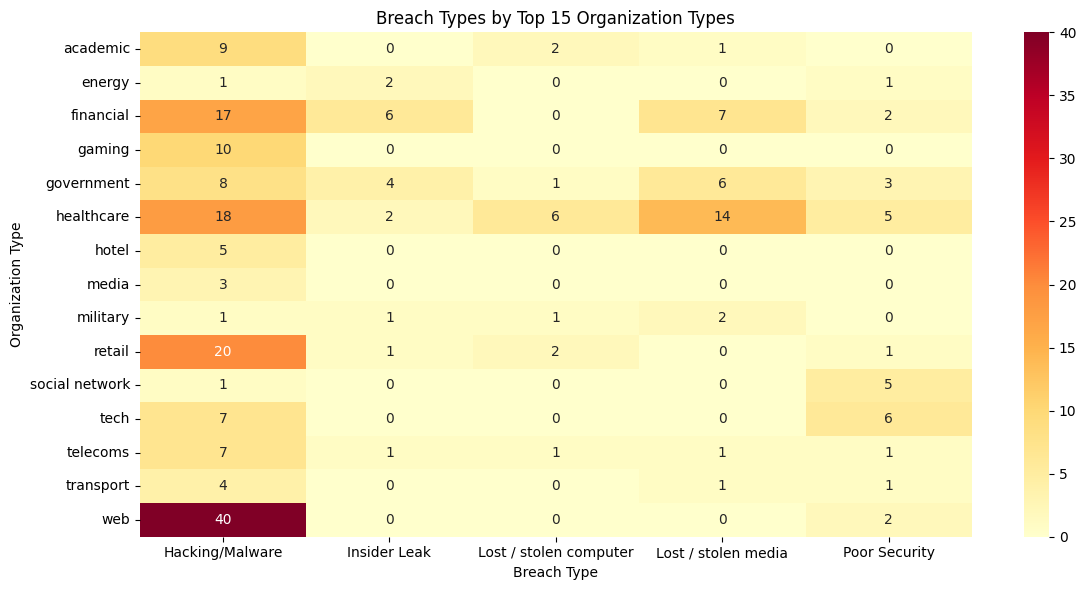


Organizational Risk Metrics:
                                                                          breach_frequency  avg_records_lost  risk_score
Organization type                                                                                                       
web                                                                                     49      1.061979e+08  905.559917
healthcare                                                                              46      3.720491e+06  695.950854
financial                                                                               36      2.273881e+07  609.825012
government                                                                              29      7.150030e+06  457.696192
retail                                                                                  25      1.488565e+07  412.897700
tech                                                                                    14      7.149271e+07  253.191486
te

In [10]:
run_complete_analysis(df)